In [2]:
import os
import pandas as pd
import glob
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from ispots.anomaly_detector import AutoAD, Preprocessor

In [3]:
# load data into a dictionary
path = os.path.abspath('../JC/electrical')
csv_files = glob.glob(os.path.join(path, "*.csv"))
pre_data_dict = {}
for f in csv_files:
    df = pd.read_csv(f)
    pre_data_dict[f.split("/")[-1][:-4]] = df

During preprocessing, measuring points with missing values more than the miss_val_threshold will be removed from the data dictionary and no further analysis will be performed.

In [4]:
# preprocess data
preprocessor = Preprocessor(pre_data_dict, miss_val_threshold = 0.01)
data_dict = preprocessor.preprocess()


dsta_blk-126-elect: missing values 47
dsta_blk-221-elect: missing values 32
dsta_blk-302-elect: missing values 38
dsta_blk-101-elect: missing values 24
dsta_blk-127-elect: missing values 32
dsta_blk-201-elect: missing values 37
dsta_blk-303-elect: missing values 31
dsta_blk-100-elect: missing values 40
dsta_blk-322-elect: missing values 34
dsta_blk-207-elect: missing values 34
dsta_blk-213-elect: missing values 32
dsta_blk-124-elect: missing values 36
dsta_blk-223-elect: missing values 33
dsta_blk-216-elect: missing values 33
dsta_blk-202-elect: missing values 31
dsta_blk-209-elect: missing values 39


To identify anomalies on 1 date, the following cell can be run. 

In this example, all measuring points in the data dictionary are analysed for anomalies.

Instead of specifying 1 date, you can also include a range of dates for anomaly detection. Ensure that the data for 90 (+ buffer) days prior to the start date is available in the data dictionary. 

For measuring points with weekday-weekend consumption difference, buffer = 7. Otherwise, buffer = 5.

In the following, we detect for anomalies in the measuring point 'aircon-load-elect' over the period 2022-12-1 to 2022-12-31.

Namespace: JC
NO 1 anomalous measuring point: dsta_blk-218-elect
Date of detection: 2023-02-02
Deviation: 790858.8 Wh, Deviation %: 302.48%


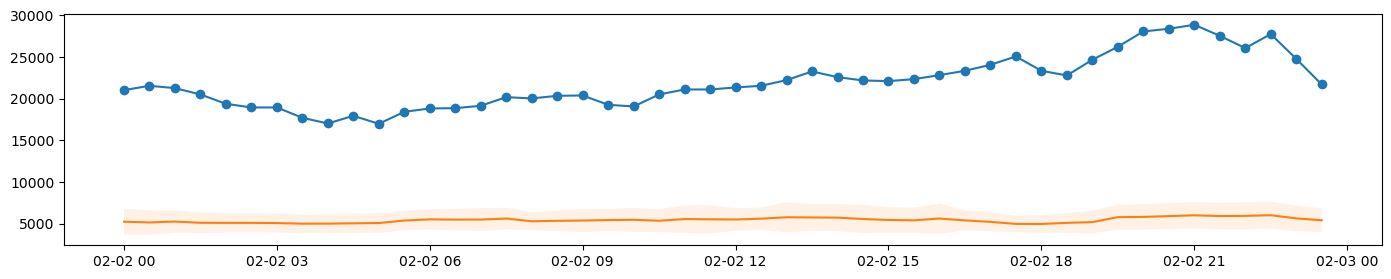

Level Shift Anomaly observed
Level shift observed from 2023-02-02 00:00:00 to 2023-02-02 23:30:00 
Deviation: 790858.8 Wh, Deviation % = 302.48% 



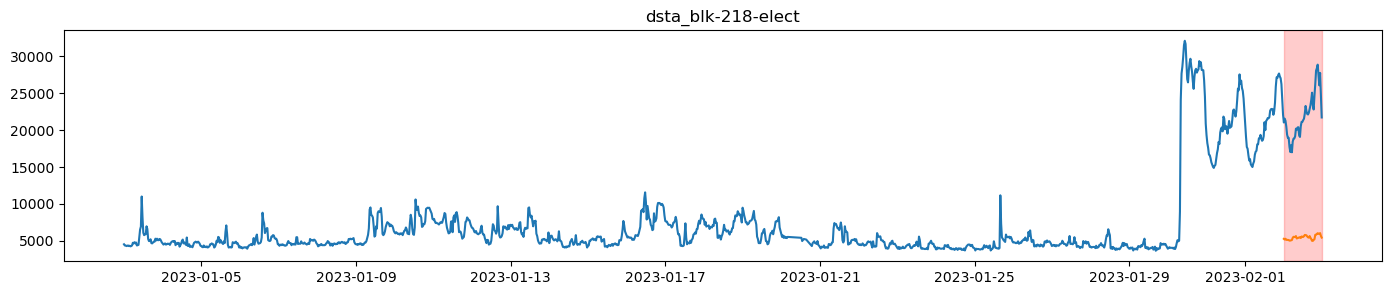

Namespace: JC
NO 2 anomalous measuring point: dsta_blk-218-elect
Date of detection: 2023-02-01
Deviation: 728662.64 Wh, Deviation %: 278.48%


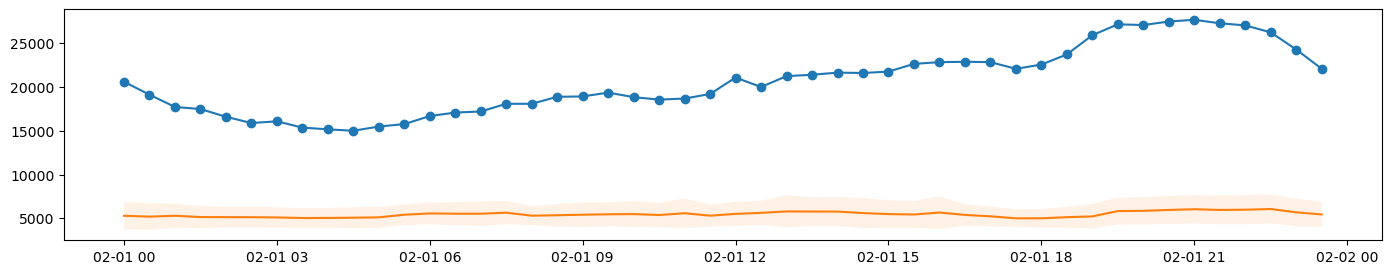

Level Shift Anomaly observed
Level shift observed from 2023-02-01 00:00:00 to 2023-02-01 23:30:00 
Deviation: 728662.64 Wh, Deviation % = 278.48% 



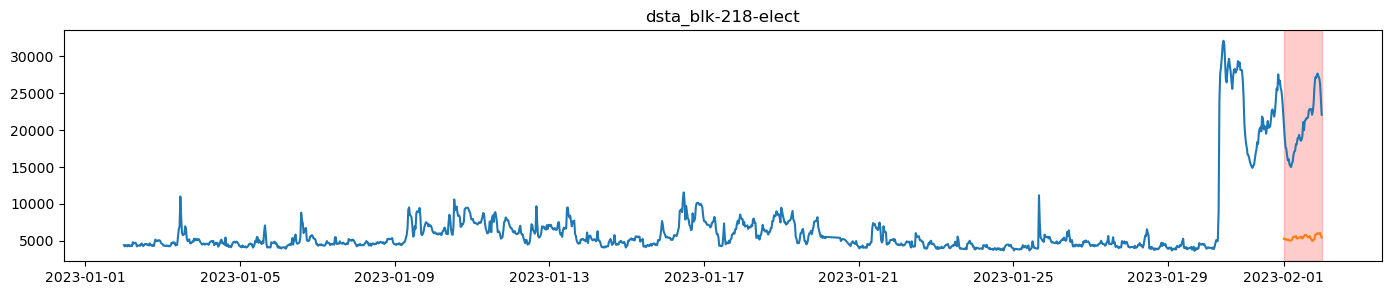

Namespace: JC
NO 3 anomalous measuring point: dsta_blk-218-elect
Date of detection: 2023-02-03
Deviation: 487918.67 Wh, Deviation %: 186.16%


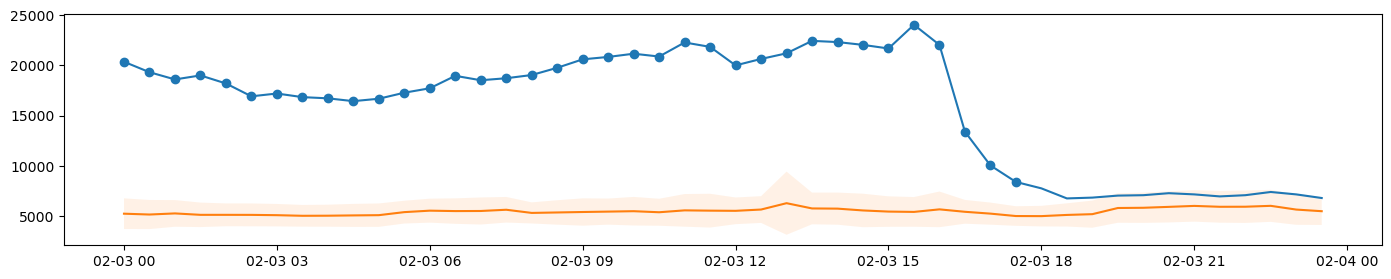

Sequence Anomaly observed
Sequence Anomaly observed from 2023-02-03 00:00:00 to 2023-02-03 17:30:00 
Deviation: 487918.67 Wh, Deviation % = 186.16% 



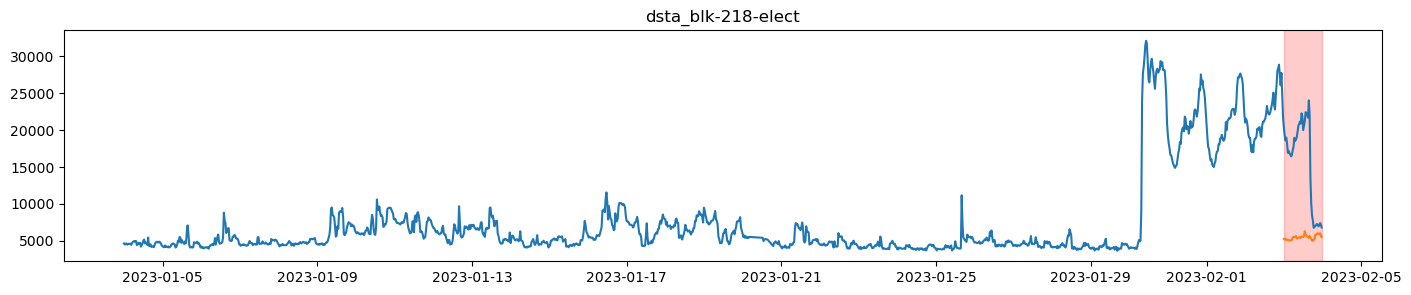

Namespace: JC
NO 4 anomalous measuring point: dsta_blk-301-elect
Date of detection: 2023-02-25
Deviation: 147530.0 Wh, Deviation %: 37.22%


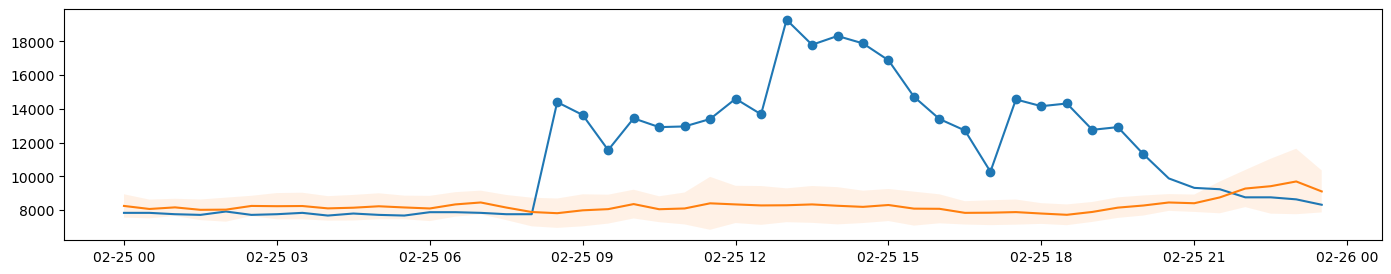

Sequence Anomaly observed
Sequence Anomaly observed from 2023-02-25 08:30:00 to 2023-02-25 20:00:00 
Deviation: 147530.0 Wh, Deviation % = 37.22% 



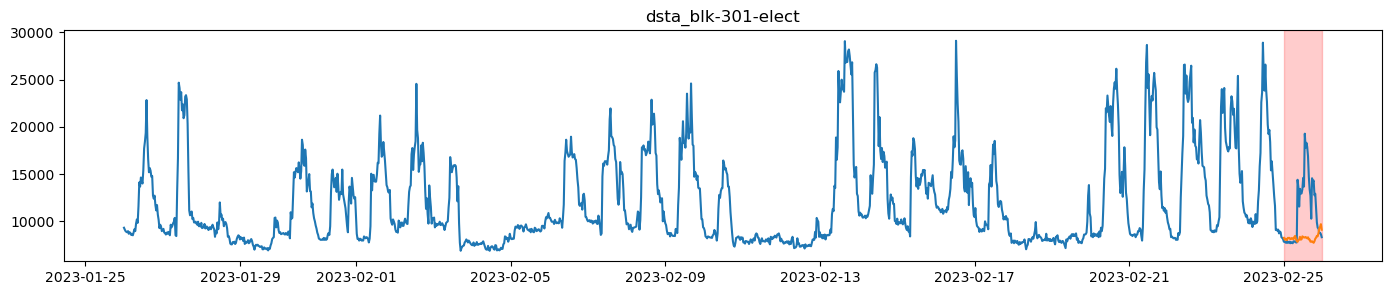

Namespace: JC
NO 5 anomalous measuring point: dsta_blk-102-elect
Date of detection: 2023-02-11
Deviation: 61777.5 Wh, Deviation %: 22.81%


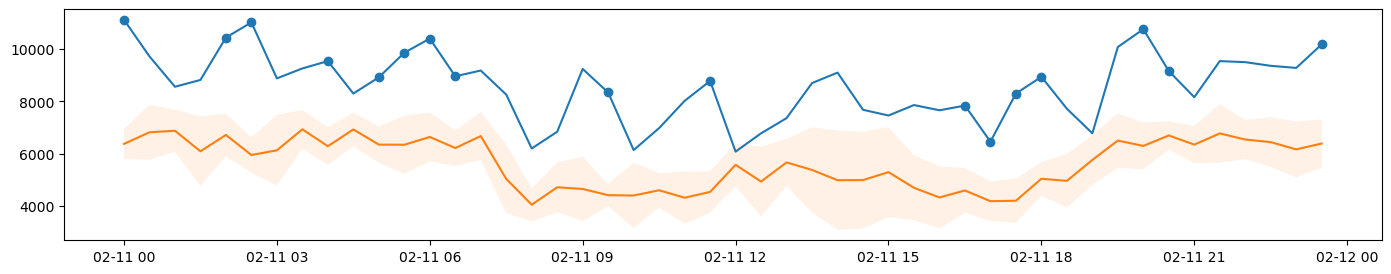

Sequence Anomaly observed
Sequence Anomaly observed from 2023-02-11 02:00:00 to 2023-02-11 20:30:00 
Deviation: 45077.5 Wh, Deviation % = 16.64% 
Number of Point Anomaly observed: 4 
Point Anomaly observed at 2023-02-11 00:00:00 
Deviation: 4745.0 Wh, Deviation % = 2.0% 
Point Anomaly observed at 2023-02-11 09:30:00 
Deviation: 3925.0 Wh, Deviation % = 1.0% 
Point Anomaly observed at 2023-02-11 11:30:00 
Deviation: 4240.0 Wh, Deviation % = 2.0% 
Point Anomaly observed at 2023-02-11 23:30:00 
Deviation: 3790.0 Wh, Deviation % = 1.0% 



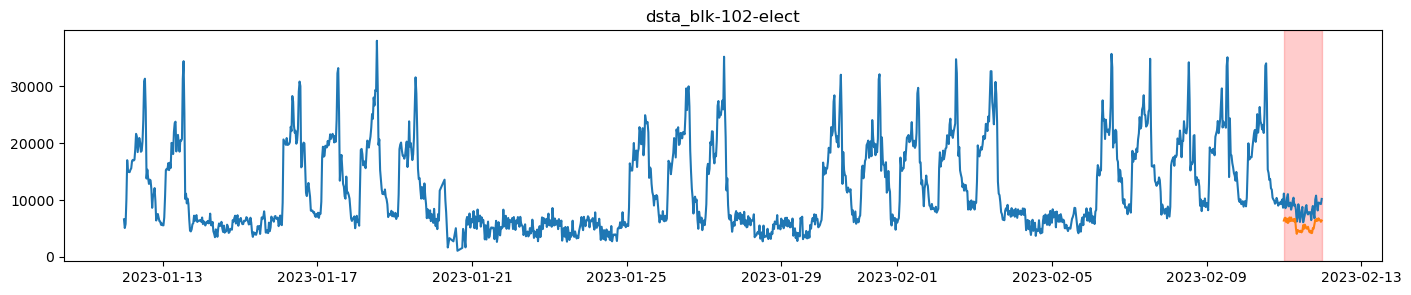

In [8]:
# statistic method
anomalies_detected_dates = []
lookback_period = 30
sort_by = 'deviation_percentage'
dev_perc_threshold = 5
namespace = 'JC'
unit_of_measurement = 'Wh'

ad_detector = AutoAD(namespace = 'JC', data_frequency = preprocessor.data_frequency, method = 'statistic', unit_of_measurement = unit_of_measurement, lookback_period = lookback_period)

start_date = pd.to_datetime('2023-2-1') 
end_date = pd.to_datetime('2023-2-28')    
score_dict = ad_detector.detect(data_dict = data_dict, detect_date = start_date)
score_dict_copy = score_dict.copy()
for mp in score_dict.keys():
    mp_new = str(mp) + str(start_date.date())
    score_dict_copy[mp_new] = score_dict_copy.pop(mp)
score_dict = score_dict_copy

detection_date = start_date + pd.Timedelta(1, unit='d')
while detection_date <= end_date:
    score_dict_append = ad_detector.detect(data_dict = data_dict, detect_date = detection_date)
    score_dict_copy = score_dict_append.copy()
    for mp in score_dict_append.keys():
        mp_new = str(mp) + str(detection_date.date())
        score_dict_copy[mp_new] = score_dict_copy.pop(mp)
    score_dict_append = score_dict_copy
    score_dict.update(score_dict_append)
    detection_date += pd.Timedelta(1, unit='d')

score_lst = list(score_dict.values())
score_lst.sort(reverse = True, key = lambda x:x[sort_by]) # use deviation to sort
# report the top 5 anomalies 
count = 0
for i in range(min(5, len(data_dict))):
    if count == min(5, len(data_dict)): 
        break
    # measuring point is reported only if total percentage deviation exceeds threshold
    if np.abs(score_lst[i]['deviation_percentage']) < dev_perc_threshold: 
        continue
    else:
        # retrieve values on measuring point
        mp = score_lst[i]['measuring point']
        score_df = score_lst[i]['score dataframe']
        deviation_val = score_lst[i]['deviation']
        deviation_per = score_lst[i]['deviation_percentage']
        date = score_df.index[0].date()

        count += 1
        # print overall anomaly message
        print(f'Namespace: {namespace}')
        print(f'NO {count} anomalous measuring point: {mp}')
        print(f'Date of detection: {date}')
        print(f'Deviation: {deviation_val} {unit_of_measurement}, Deviation %: {deviation_per}%')

        # retrieve data for detection date + look back period
        full_df = data_dict[mp]
        long_df = full_df.loc[(full_df.index <= score_df.index[-1]) & 
                            (full_df.index >= score_df.index[0] - dt.timedelta(days=lookback_period))].copy()
        
        # plot the consumption data for reference
        #if plot:
            # plot for detection date
        fig, ax = plt.subplots(figsize=(17, 3))
        ax.plot(score_df.index, score_df.Value)
        ax.plot(score_df.index, score_df.pred)
        ax.scatter(score_df[score_df.anomaly == True].index, score_df[score_df.anomaly == True].Value)
        ax.fill_between(score_df.index, score_df.pred_low, score_df.pred_high, alpha = 0.1)
        plt.show()
        ax.figure.savefig('./' + mp +'test.png') #,  bbox_inches = 'tight') #30SCE_monthly.png

        #if report:
        # generate anomaly message
        anomaly_message = ad_detector.anomaly_message(score_df)
        print(anomaly_message)

        # plot detection date + lookback period
        fig, ax = plt.subplots(figsize=(17, 3))
        ax.plot(long_df.index, long_df.Value)
        ax.plot(score_df.index, score_df.pred)
        ax.axvspan(score_df.index[0], score_df.index[-1], alpha=0.2, color='r')
        ax.title.set_text(mp)
        plt.show()
    
    #ad_detector.top_k(k = 1, sort_by = 'deviation_percentage', report = True, plot = True, dev_perc_threshold = 5)
#if count > 0:
#    anomalies_detected_dates.append(detection_date)
    #detection_date += pd.Timedelta(1, unit='d')
